### Diffusion Completion Probe

This notebook demonstrates the *Diffusion Completion Probe* used in our paper to evaluate concept erasure. 
The idea is to start a generation using the original (unerased) base model up to a specific diffusion step, 
then switch to an erased model to complete the generation. If the erased concept still appears in the final image, 
it suggests that the erased model can recover and complete the concept from partial context—indicating incomplete erasure.

We visualize and compare reconstructions across different erasure methods and interruption steps.

Our experiments depend on the usage of a patched stable diffusion pipeline to create the "dt_latents" as well as run custom timesteps on input latents.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DDIMScheduler
from utils.sdv14 import call_sdv14
import warnings
warnings.filterwarnings("ignore", message=".*IProgress not found.*")
StableDiffusionPipeline.__call__ = call_sdv14
StableDiffusionPipeline._callback_tensor_inputs = ["dt_latents", "latents", "prompt_embeds", "negative_prompt_embeds"]
%config InlineBackend.figure_format = 'jpg'

# Lower DPI and default figure size
plt.rcParams['figure.dpi'] = 75        # smaller resolution
device = "cuda"
num_inference_steps = 50

#Diffusion Completion Steps
interrupt_steps = [1, 2, 3, 5, 10, 15, 20]
# === Load base pipeline ===
base_pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.bfloat16
).to(device).to(torch.bfloat16)
base_pipe.scheduler = DDIMScheduler.from_config(base_pipe.scheduler.config)
base_pipe.set_progress_bar_config(disable=True)

# === Latent Decoding helper ===
def decode_latent(latent):
    if latent.dim() == 3:
        latent = latent.unsqueeze(0)
    latent = latent.to(device) / 0.18215
    with torch.no_grad():
        decoded = base_pipe.vae.decode(latent).sample
    image = (decoded.clamp(-1, 1) + 1) / 2
    return image[0].permute(1, 2, 0).float().cpu().numpy()

def generate_base_latents(prompt, interrupt_steps, seed):
    interrupted_latents = []
    dt_images = []

    for t_step in interrupt_steps:
        gen = torch.Generator(device=device).manual_seed(seed)

        def interrupt_callback(pipeline, i, t, callback_kwargs):
            if i == t_step:
                pipeline._interrupt = True
                interrupted_latents.append(callback_kwargs["latents"].clone())
            return callback_kwargs

        base_pipe.scheduler.set_timesteps(num_inference_steps)
        _ = base_pipe(
            prompt,
            generator=gen,
            num_inference_steps=num_inference_steps,
            output_type="latent",
            callback_on_step_end=interrupt_callback,
        )

        run_timesteps = base_pipe.scheduler.timesteps[t_step+1:]

        def dt_callback(pipeline, i, t, callback_kwargs):
            pipeline._interrupt = True
            return callback_kwargs

        base_pipe.scheduler.set_timesteps(num_inference_steps)

        #Output_type = dt_image, check the utils file to see what's going on inside!
        dt = base_pipe(
            prompt,
            generator=torch.Generator(device=device).manual_seed(seed),
            num_inference_steps=num_inference_steps,
            run_timesteps=run_timesteps,
            latents=interrupted_latents[-1].clone(),
            callback_on_step_end=dt_callback
        ).images[0]
        dt_images.append(dt)

    return interrupted_latents, dt_images

def diffusion_completion(base_prompt, completion_prompt, concept, interrupt_steps, erased_model_paths, seed=0):
    base_prompt = base_prompt.replace("_", " ")
    prompt_clean = completion_prompt.replace("_", " ")
    
    # === Step 1: Generate interrupted latents and base completions ===
    base_latents, dt_images = generate_base_latents(base_prompt, interrupt_steps, seed)

    # === Step 2: Run reconstruction for each erased model ===
    all_recons = {"base": []}

    for idx, t_step in enumerate(interrupt_steps):
        latent = base_latents[idx]
        base_pipe.scheduler.set_timesteps(num_inference_steps)
        timesteps = base_pipe.scheduler.timesteps
        run_timesteps = timesteps[t_step + 1:]

        base_recon = base_pipe(
            base_prompt,
            generator=torch.Generator(device=device).manual_seed(seed),
            num_inference_steps=num_inference_steps,
            output_type="latent",
            run_timesteps=run_timesteps,
            latents=latent
        ).images[0]
        
        all_recons["base"].append(decode_latent(base_recon))
    for erased_path in erased_model_paths:
        erased_path = f"{erased_path}_{concept}"
        model_name = os.path.basename(erased_path)
        print(f"Running recon for: {model_name}")

        # Load erased model
        erased_pipe = StableDiffusionPipeline.from_pretrained(
            erased_path, torch_dtype=torch.bfloat16
        ).to(device).to(torch.bfloat16)
        erased_pipe.scheduler = DDIMScheduler.from_config(base_pipe.scheduler.config)
        erased_pipe.scheduler.set_timesteps(num_inference_steps)
        
        #Uncomment to get rid of all the progress bars
        erased_pipe.set_progress_bar_config(disable=True)

        recon_images = []
        for idx, t_step in enumerate(interrupt_steps):
            latent = base_latents[idx]
            base_pipe.scheduler.set_timesteps(num_inference_steps)
            timesteps = base_pipe.scheduler.timesteps

            #Complete the diffusion process with the rest of the timesteps
            run_timesteps = timesteps[t_step + 1:]

            recon = erased_pipe(
                prompt_clean,
                generator=torch.Generator(device=device),
                num_inference_steps=num_inference_steps,
                output_type="latent",
                run_timesteps=run_timesteps,
                latents=latent
            ).images[0]

            recon_images.append(decode_latent(recon))

        all_recons[model_name] = recon_images

    return dt_images, all_recons

def display_full_grid(dt_images, all_recons, interrupt_steps):
    model_names = list(all_recons.keys())
    num_models = len(model_names)
    num_rows = len(interrupt_steps)
    num_cols = num_models + 1  # +1 for base model

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    for row in range(num_rows):
        axes[row][0].imshow(dt_images[row])
        axes[row][0].set_title(f"Base @ t={interrupt_steps[row]}")
        axes[row][0].axis("off")

        for col, model_name in enumerate(model_names):
            axes[row][col + 1].imshow(all_recons[model_name][row])
            axes[row][col + 1].set_title(f"{model_name} Recon")
            axes[row][col + 1].axis("off")

    plt.tight_layout()
    plt.show()



/share/u/kevin/miniconda3/envs/asdf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:54<00:00,  7.74s/it]


### What are `dt_latents`?

At each diffusion step, `dt_latents` stores the model's prediction of the *original clean latent* (`x0`) before any noise was added. It's computed from the current noisy latent (`xt`) and the predicted noise, and can be decoded with the VAE to visualize intermediate reconstructions during generation.


In [ ]:
erased_model_paths = [
    "DiffusionConceptErasure/esdx",
    "DiffusionConceptErasure/uce",
    "DiffusionConceptErasure/stereo",
    "DiffusionConceptErasure/rece",
]

base_prompt = "a picture of a garbage truck"
completion_prompt = "a a picture of a garbage truck"
dt_images, all_recons = diffusion_completion(base_prompt, completion_prompt, concept="garbage_truck", interrupt_steps=interrupt_steps, erased_model_paths=erased_model_paths, seed = 42)
display_full_grid(dt_images, all_recons, interrupt_steps)

Running recon for: uce_van_gogh


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Running recon for: tv_van_gogh


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.73it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Running recon for: stereo_van_gogh


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.66it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


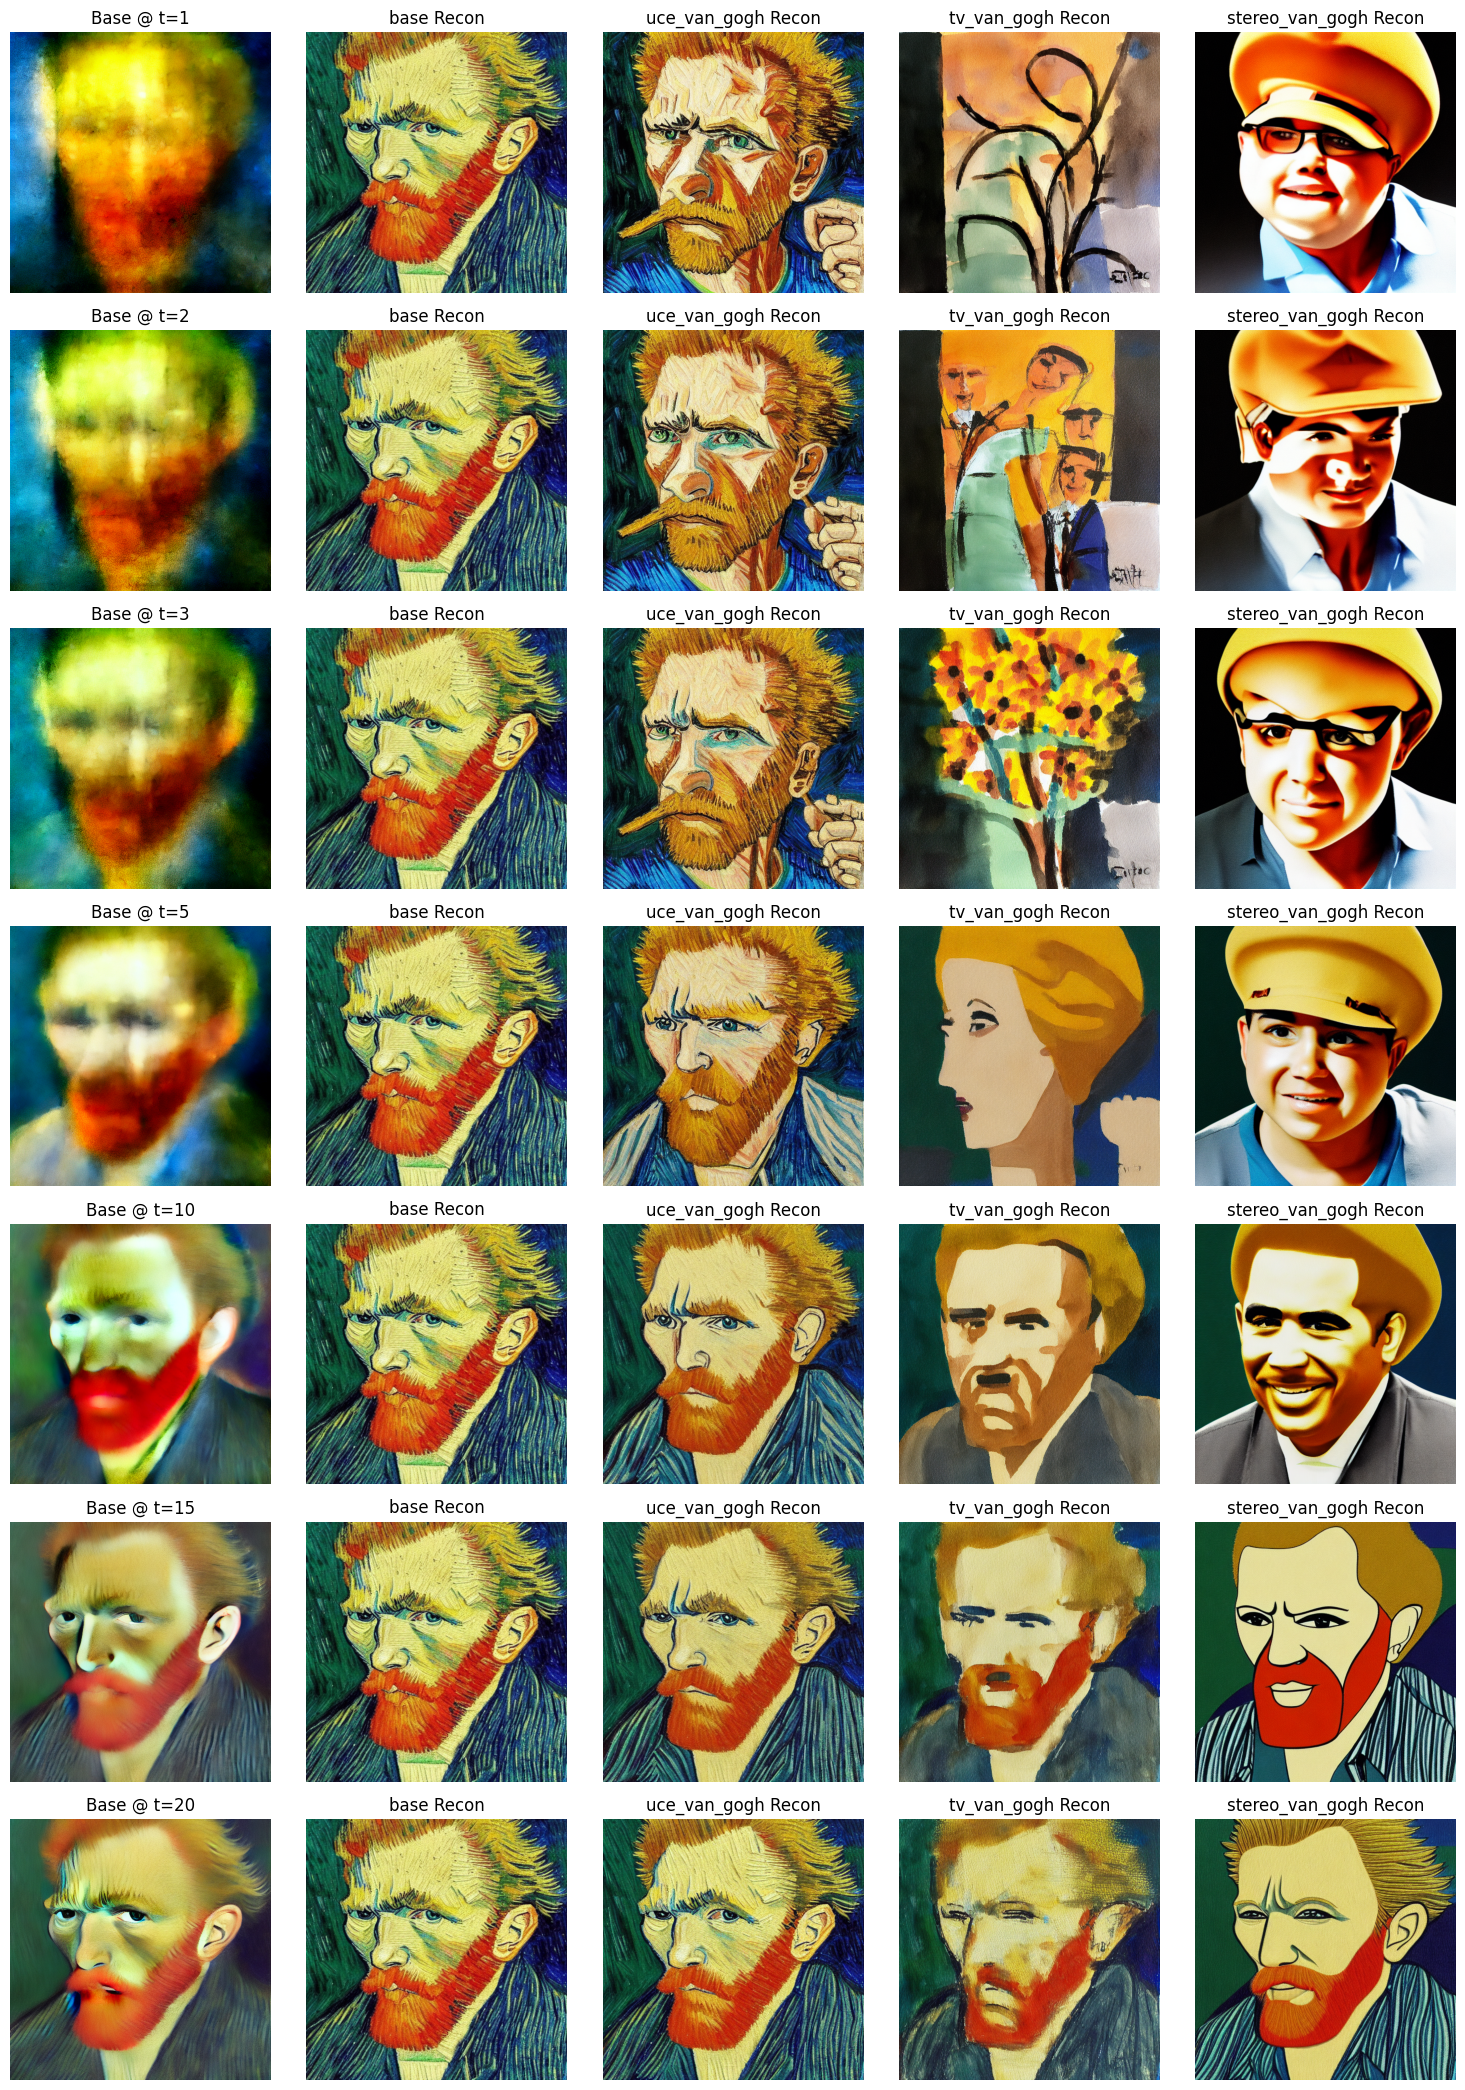

In [ ]:
erased_model_paths = [
    "DiffusionConceptErasure/esdx",
    "DiffusionConceptErasure/uce",
    "DiffusionConceptErasure/stereo",
    "DiffusionConceptErasure/rece",
]

base_prompt = "a painting in the style of Van Gogh"
completion_prompt = "a painting in the style of Van Gogh"
dt_images, all_recons = diffusion_completion(base_prompt, completion_prompt, concept="van_gogh", interrupt_steps=interrupt_steps, erased_model_paths=erased_model_paths)
display_full_grid(dt_images, all_recons, interrupt_steps)